In [1]:
import sys
import os
sys.path.append(os.path.abspath("C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code"))
import hdf5storage
import mat73
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math



import CURBD.curbd as curbd
import PyalData.pyaldata as pyaldata

In [2]:
data_dir_WTM350 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2" 
data_dir_WTM355 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2" 
data_dir_ASM351 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2" 
data_dir_ASM354 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2" 
data_dir_PSM365 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2" 
data_dir_PSM366 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2" 

In [3]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=50)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=50,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                [curbd_arr, curbd_labels] = curbd.computeCURBD(model)

                magn_m1tom1 = sum(abs(curbd_arr[0][0]))
                baseline_m1tom1 = np.mean(magn_m1tom1[0:250])
                strength_m1tom1 = math.sqrt(sum(np.power((magn_m1tom1[250:500]-baseline_m1tom1),2))/250)
                current_magn_strengths[animal_model]['m1 to m1'].append(strength_m1tom1)

                magn_dcntom1 = sum(abs(curbd_arr[0][1]))
                baseline_dcntom1 = np.mean(magn_dcntom1[0:250])
                strength_dcntom1 = math.sqrt(sum(np.power((magn_dcntom1[250:500]-baseline_dcntom1),2))/250)
                current_magn_strengths[animal_model]['dcn to m1'].append(strength_dcntom1)

                magn_strtom1 = sum(abs(curbd_arr[0][2]))
                baseline_strtom1 = np.mean(magn_strtom1[0:250])
                strength_strtom1 = math.sqrt(sum(np.power((magn_strtom1[250:500]-baseline_strtom1),2))/250)
                current_magn_strengths[animal_model]['str to m1'].append(strength_strtom1)

                magn_m1todcn = sum(abs(curbd_arr[1][0]))
                baseline_m1todcn = np.mean(magn_m1todcn[0:250])
                strength_m1todcn = math.sqrt(sum(np.power((magn_m1todcn[250:500]-baseline_m1todcn),2))/250)
                current_magn_strengths[animal_model]['m1 to dcn'].append(strength_m1todcn)

                magn_dcntodcn = sum(abs(curbd_arr[1][1]))
                baseline_dcntodcn = np.mean(magn_dcntodcn[0:250])
                strength_dcntodcn = math.sqrt(sum(np.power((magn_dcntodcn[250:500]-baseline_dcntodcn),2))/250)
                current_magn_strengths[animal_model]['dcn to dcn'].append(strength_dcntodcn)

                magn_strtodcn = sum(abs(curbd_arr[1][2]))
                baseline_strtodcn = np.mean(magn_strtodcn[0:250])
                strength_strtodcn = math.sqrt(sum(np.power((magn_strtodcn[250:500]-baseline_strtodcn),2))/250)
                current_magn_strengths[animal_model]['str to dcn'].append(strength_strtodcn)

                magn_m1tostr = sum(abs(curbd_arr[2][0]))
                baseline_m1tostr = np.mean(magn_m1tostr[0:250])
                strength_m1tostr = math.sqrt(sum(np.power((magn_m1tostr[250:500]-baseline_m1tostr),2))/250)
                current_magn_strengths[animal_model]['m1 to str'].append(strength_m1tostr)

                magn_dcntostr = sum(abs(curbd_arr[2][1]))
                baseline_dcntostr = np.mean(magn_dcntostr[0:250])
                strength_dcntostr = math.sqrt(sum(np.power((magn_dcntostr[250:500]-baseline_dcntostr),2))/250)
                current_magn_strengths[animal_model]['dcn to str'].append(strength_dcntostr)

                magn_strtostr = sum(abs(curbd_arr[2][2]))
                baseline_strtostr = np.mean(magn_strtostr[0:250])
                strength_strtostr = math.sqrt(sum(np.power((magn_strtostr[250:500]-baseline_strtostr),2))/250)
                current_magn_strengths[animal_model]['str to str'].append(strength_strtostr)


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session10.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session11.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session12.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session13.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session14.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session15.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [6

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session17.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session18.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session19.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session20.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session21.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session23.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session9.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2\PS-M365_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [2

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2\PS-M365_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2\PS-M365_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2\PS-M366_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18800\3929780518.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4

C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2\PS-M366_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2\PS-M366_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [4]:
current_magn_strengths

{'WT-M350': {'m1 to m1': [0.24166180142811414,
   0.5270802513013758,
   0.3070019772432503,
   0.5506947465586771,
   2.31599851332963,
   3.0464427742182254,
   3.193932436935151],
  'dcn to m1': [0.26754085591183585,
   0.7442650157081961,
   0.4737272867286965,
   0.7863145591898003,
   2.2693330604323894,
   0.6399384010380432,
   1.861637475646111],
  'str to m1': [0.15426539714991147,
   0.556862386616195,
   0.36755843629682183,
   0.5106879958076433,
   1.850666172352445,
   2.3898938974395,
   3.6393966407619813],
  'm1 to dcn': [0.5330687404534609,
   1.4482817158578964,
   1.3346676182481447,
   2.108698937167095,
   1.4201732535778995,
   2.388346008721213,
   1.8180540151074318],
  'dcn to dcn': [1.1987534909104067,
   1.6184340136134803,
   2.0758774992921456,
   2.6395981727619118,
   1.0891966926487304,
   0.9313416410183676,
   1.4825983443922774],
  'str to dcn': [0.7634274154368738,
   1.3907611011611314,
   0.8379156556814978,
   1.5370547542108188,
   1.2424735026

In [5]:
import json

# Convert the dictionary to a JSON-formatted string
json_string = json.dumps(current_magn_strengths, indent=4)

# Write the JSON string to a file
with open('current_magn_strengths_dict.json', 'w') as json_file:
    json_file.write(json_string)

([<matplotlib.axis.XTick at 0x25fb0e16860>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

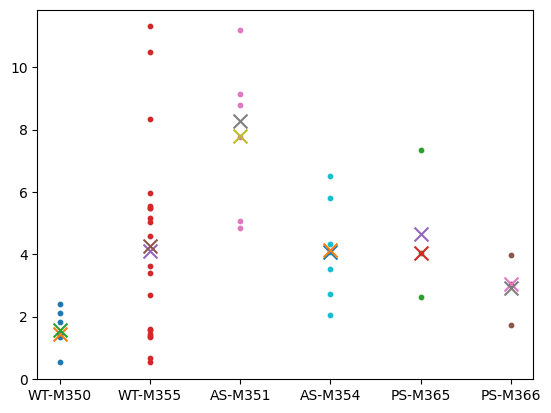

In [6]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['m1 to dcn'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['m1 to dcn']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['m1 to dcn'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

([<matplotlib.axis.XTick at 0x25fb6ed0610>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

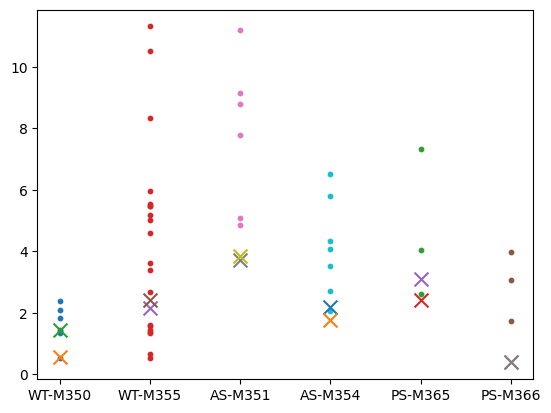

In [7]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['m1 to m1'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['m1 to m1']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['m1 to m1'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

([<matplotlib.axis.XTick at 0x25fc201d210>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

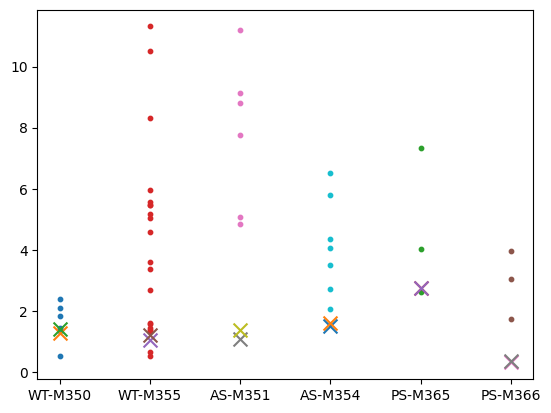

In [8]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['m1 to str'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['m1 to str']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['m1 to str'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

([<matplotlib.axis.XTick at 0x25fc1e70190>,
 [Text(1, 0, 'WT-M350'),
  Text(2, 0, 'WT-M355'),
  Text(3, 0, 'AS-M351'),
  Text(4, 0, 'AS-M354'),
  Text(5, 0, 'PS-M365'),
  Text(6, 0, 'PS-M366')])

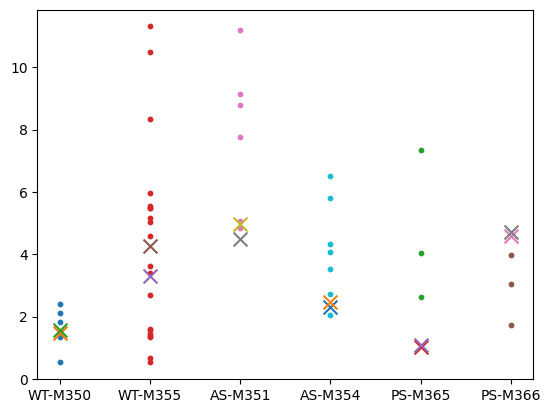

In [9]:
import statistics

i = 1
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    plt.scatter(i*np.ones(len(current_magn_strengths[animal_model]['dcn to dcn'])),current_magn_strengths[animal_model]['m1 to dcn'], s=10)  # or should we plot the median for each session instead of mean?
    plt.scatter(i,statistics.median(current_magn_strengths[animal_model]['dcn to dcn']), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    plt.scatter(i,np.mean(list(current_magn_strengths[animal_model]['dcn to dcn'])), marker='x', s=100)  # median of average (mean) duration of movement execution for each session
    i +=1

plt.xticks([1,2,3,4,5,6],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])

# note that on the y-axis we have time in time bins, where each time bin is 2 ms

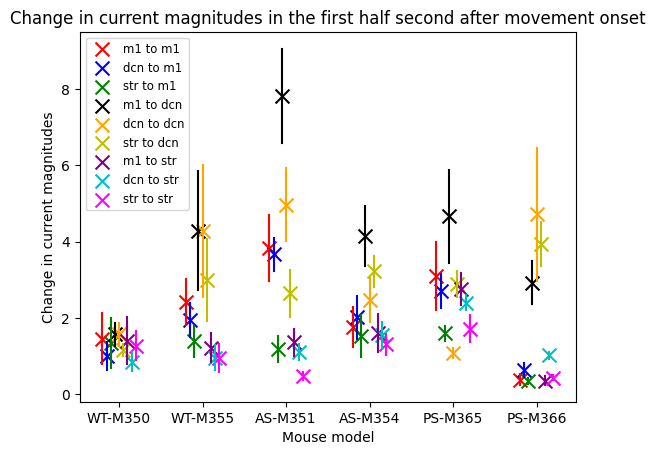

In [36]:
import statistics

# Using mean and standard deviation (obs: need normal distribution)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.mean(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        plt.plot([i,i], [statistics.mean(current_magn_strengths[animal_model][current])-statistics.stdev(current_magn_strengths[animal_model][current])/2,statistics.mean(current_magn_strengths[animal_model][current])+statistics.stdev(current_magn_strengths[animal_model][current])/2], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')

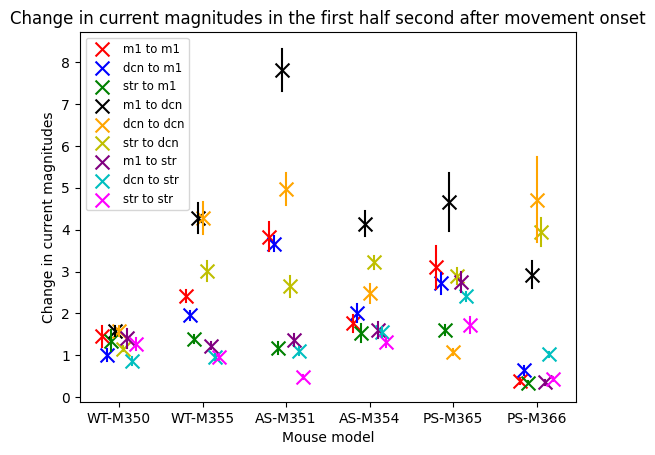

In [33]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.mean(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        plt.plot([i,i], [statistics.mean(current_magn_strengths[animal_model][current])-scipy.stats.sem(current_magn_strengths[animal_model][current])/2,statistics.mean(current_magn_strengths[animal_model][current])+scipy.stats.sem(current_magn_strengths[animal_model][current])/2], color=colors_list[current_index], label=current)
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')

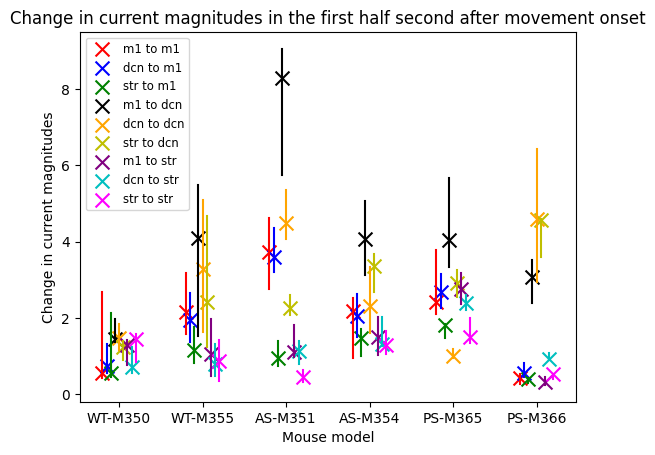

In [35]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.median(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        q1 = np.percentile(current_magn_strengths[animal_model][current], 25)
        q3 = np.percentile(current_magn_strengths[animal_model][current], 75)
        plt.plot([i,i], [q1,q3], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')


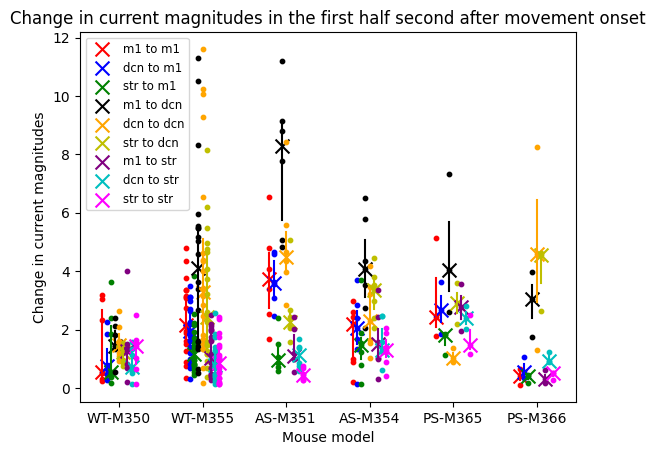

In [42]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.median(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        q1 = np.percentile(current_magn_strengths[animal_model][current], 25)
        q3 = np.percentile(current_magn_strengths[animal_model][current], 75)
        plt.plot([i,i], [q1,q3], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')


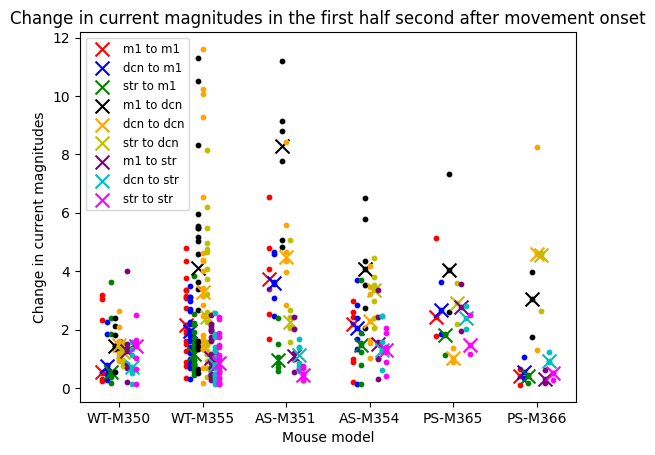

In [44]:
import statistics

import scipy.stats

# Using mean and s.e.m. (just as in CURBD fig.5g)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    current_index = 0
    for current in current_list:
        plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.median(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        q1 = np.percentile(current_magn_strengths[animal_model][current], 25)
        q3 = np.percentile(current_magn_strengths[animal_model][current], 75)
        #plt.plot([i,i], [q1,q3], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')


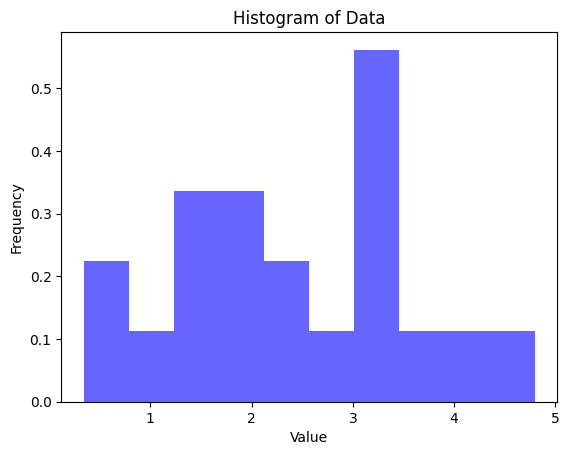

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
data = current_magn_strengths['WT-M355']['m1 to m1']

# Plot histogram
plt.hist(data, density=True, alpha=0.6, color='blue')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

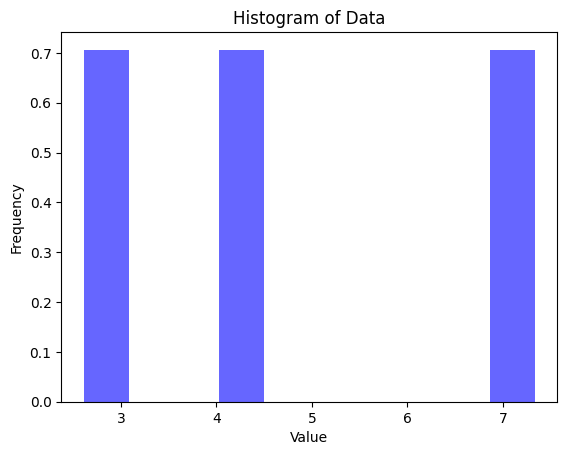

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
data = current_magn_strengths['PS-M365']['m1 to dcn']

# Plot histogram
plt.hist(data, density=True, alpha=0.6, color='blue')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()